<h1 style='color:blue' align='center'>Data Science Classificatiohn Project: Tetris Opener Classification</h1>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

<h2 style='color:blue'>Data Load: Load in and Resize Tetris Opener Images</h2>

**Manually collected different tetris openers and resized them to be 256x256. More information about the openers can be found in the README**

In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=15
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "openers",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 136 files belonging to 5 classes.


In [3]:
class_names = dataset.class_names
class_names

['Albatross', 'Hachispin', 'PCO', 'SDPC-Stickspin', 'TKI']

### Visualization of the first batch of images in our dataset

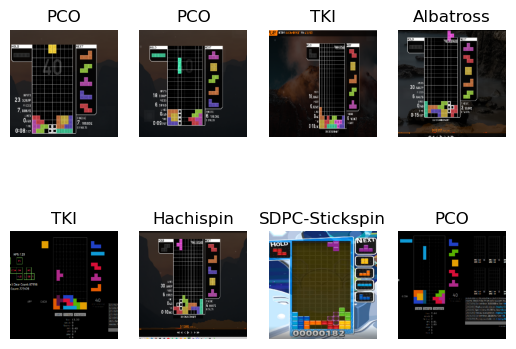

In [4]:
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<h2 style='color:blue'>Train Validate Test Split the Data</h2>

**The dataset needs to be split into 3 categories to train the Neural Network.A large set of the data is needed for training the model, a validation set is needed to test the model while it's being trained, and lastly a test set to see how to model does after being fully trained. The current model was trained with an 60,20,20 split which lead to 10 out of 17 batches being trained, 3 out of 17 being validated, and 4 out of 17 being tested**

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(val_ds), len(test_ds)

(13, 1, 3)

**Cache and prefetch the datasets to make training the model faster and shuffle the datasets one more time**

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h2 style='color:blue'>Building the Classification Model</h2>

### Creating a Layer for Resizing and Normalization

**This first layer in the neural network is meant to resize and rescale any image that is put into the model to classify after the training is done**

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

**Since I didn't have a lot of data to work with Data Augmentation is used to create more sample data to train with, which can help boost the accuracy of the model. The data augmentation included Flipping the image horizontally, adding contrast to the image by up to 40% and zooming in the image horizontally and vertically by up to 10%**

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomContrast(0.4),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.0),width_factor=(0.2, 0.0))
])

In [10]:
augmented_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

train_ds_final = train_ds.concatenate(augmented_ds).shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


**With this data augmentation, I have 2x more images to work with for our training set**

In [11]:
len(train_ds_final)

26

<h2 style='color:blue'>Model Architecture</h2>

**I used a Convolutional Neural Network (CNN) since it works well with training images.This involves repeatedly using the convolution and maxpooling layers to shrink the image and create more recognized patterns**

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (8, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (8, 62, 62, 64)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (8, 60, 60, 64)          

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds_final,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
26/26 [==============================] - 39s 1s/step - loss: 1.6314 - accuracy: 0.3702 - val_loss: 1.5954 - val_accuracy: 0.2500
Epoch 2/15
26/26 [==============================] - 28s 972ms/step - loss: 1.5362 - accuracy: 0.3942 - val_loss: 1.6015 - val_accuracy: 0.2500
Epoch 3/15
26/26 [==============================] - 29s 1s/step - loss: 1.5027 - accuracy: 0.3942 - val_loss: 1.6333 - val_accuracy: 0.2500
Epoch 4/15
26/26 [==============================] - 30s 1s/step - loss: 1.5064 - accuracy: 0.3942 - val_loss: 1.5999 - val_accuracy: 0.2500
Epoch 5/15
26/26 [==============================] - 25s 890ms/step - loss: 1.5051 - accuracy: 0.3942 - val_loss: 1.5897 - val_accuracy: 0.2500
Epoch 6/15
26/26 [==============================] - 29s 1s/step - loss: 1.4893 - accuracy: 0.3942 - val_loss: 1.6117 - val_accuracy: 0.2500
Epoch 7/15
26/26 [==============================] - 31s 1s/step - loss: 1.4686 - accuracy: 0.3942 - val_loss: 1.7160 - val_accuracy: 0.2500
Epoch 8/15
26/

In [16]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 226ms/step - loss: 1.4224 - accuracy: 0.8333


In [17]:
scores

[1.4224352836608887, 0.8333333134651184]

**With this model I managed to achieve a 83.333% accuracy for the test dataset which is very good** 

<h2 style='color:blue'>Run Predictions on Test Images</h2>

actual label: TKI
predicted label: TKI


(-0.5, 255.5, 255.5, -0.5)

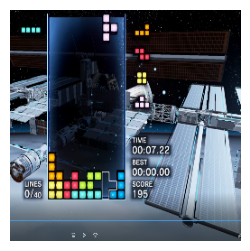

In [18]:
import numpy as np
plt.figure(figsize=(3, 3))
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch,verbose=0)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
plt.axis("off")

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array,verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

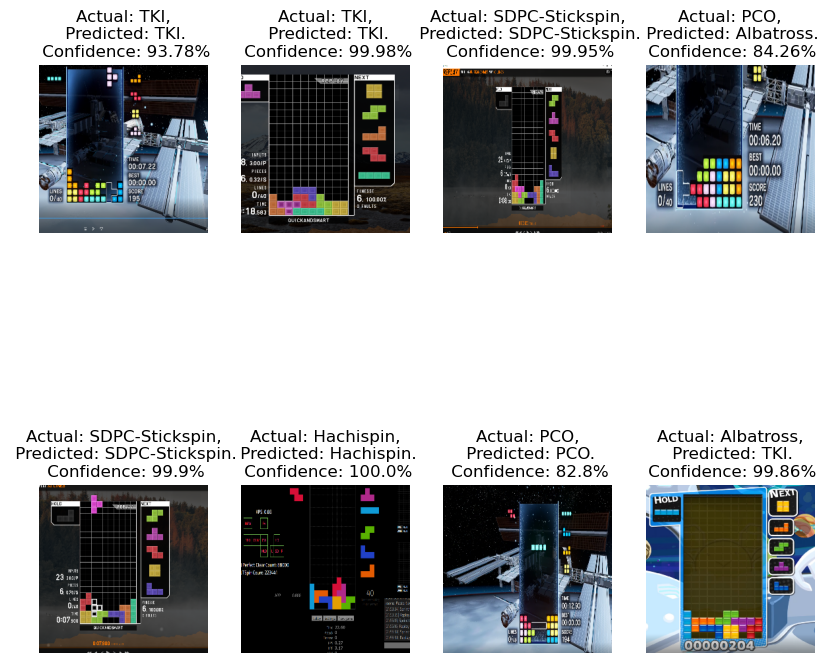

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<h2 style='color:blue'>Save the Model</h2>

**Save the model, and whenever I want to make changes to test later I can have multiple models**

In [21]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
